<a href="https://colab.research.google.com/github/yhyh4420/data-analysis-by-using-python/blob/main/data_analysis_Data_of_Body_Size_ROK_Army_Soldiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


google 드라이브를 colab에 연동

In [3]:
df = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/육군 신체측정정보.csv', encoding='euc-kr')

드라이브에 육군 신체측정정보.csv 업로드 후 읽어주기

한글을 못읽어서 encoding = 'euc-kr' 삽입하여 읽게 해줌

In [4]:
df = df.dropna()
df = df.drop(['순번', '측정 일자'], axis = 1)
df.columns = ['chest', 'sleeve', 'height', 'waist', 'length_leg', 'head', 'foot', 'weight']

결측치 제거 후 column명 변경
 * 한 → 영

<Axes: >

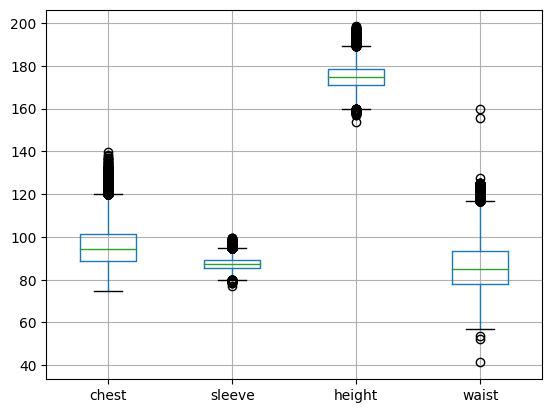

In [5]:
df.boxplot(column = ['chest', 'sleeve', 'height', 'waist'])

<Axes: >

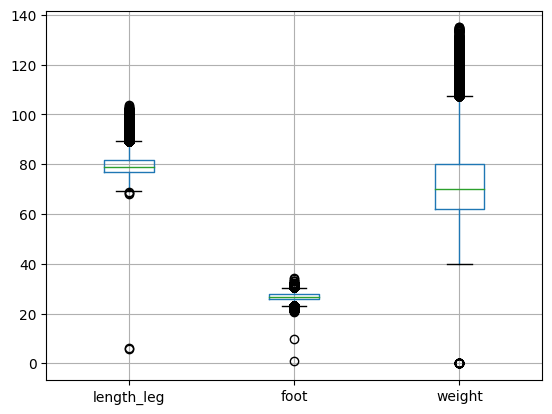

In [6]:
df.boxplot(column = ['length_leg', 'foot', 'weight'])

<Axes: >

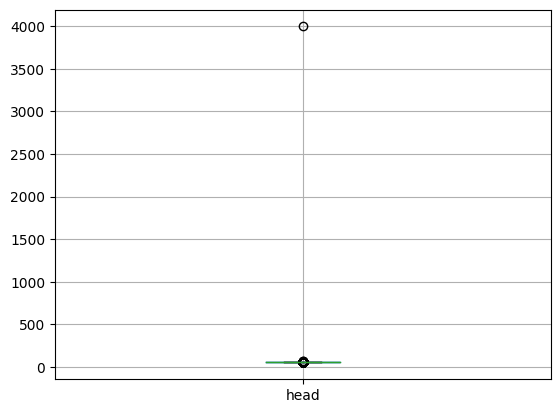

In [7]:
df.boxplot(column = ['head'])

boxplot을 통해 이상치 시각화

In [8]:
data = df.copy()
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

Q1 = 1사분위수

Q3 = 3사분위수

IQR = Q3 - Q1

In [9]:
condition = (data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))
condition = condition.any(axis = 1)

이상치를 가진 row를 True로 만드는 조건문 생성

In [10]:
Outlier = data[condition]

이상치 집합 data 생성

In [11]:
new_data = data.drop(Outlier.index, axis = 0)

이상치를 제거한 data를 new_data로 새로 저장

<Axes: >

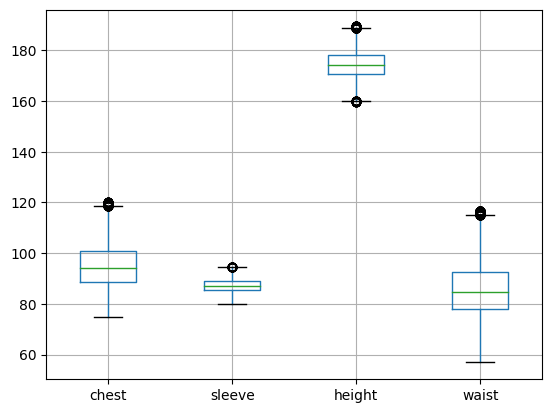

In [12]:
new_data.boxplot(column =['chest', 'sleeve', 'height', 'waist'])

<Axes: >

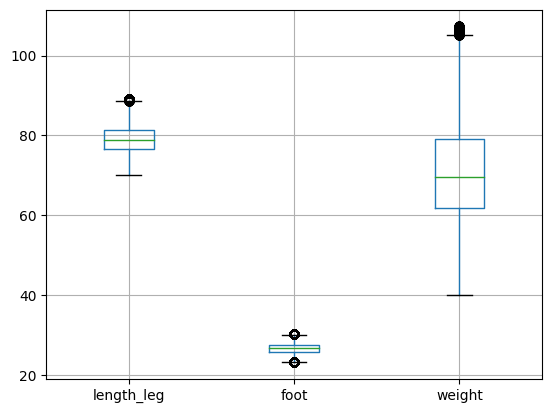

In [13]:
new_data.boxplot(column = ['length_leg', 'foot', 'weight'])

<Axes: >

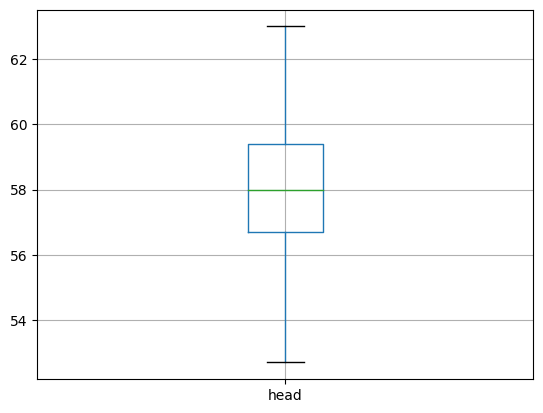

In [14]:
new_data.boxplot(column = ['head'])

boxplot 재생성해서 이상치 제거 여부 확인

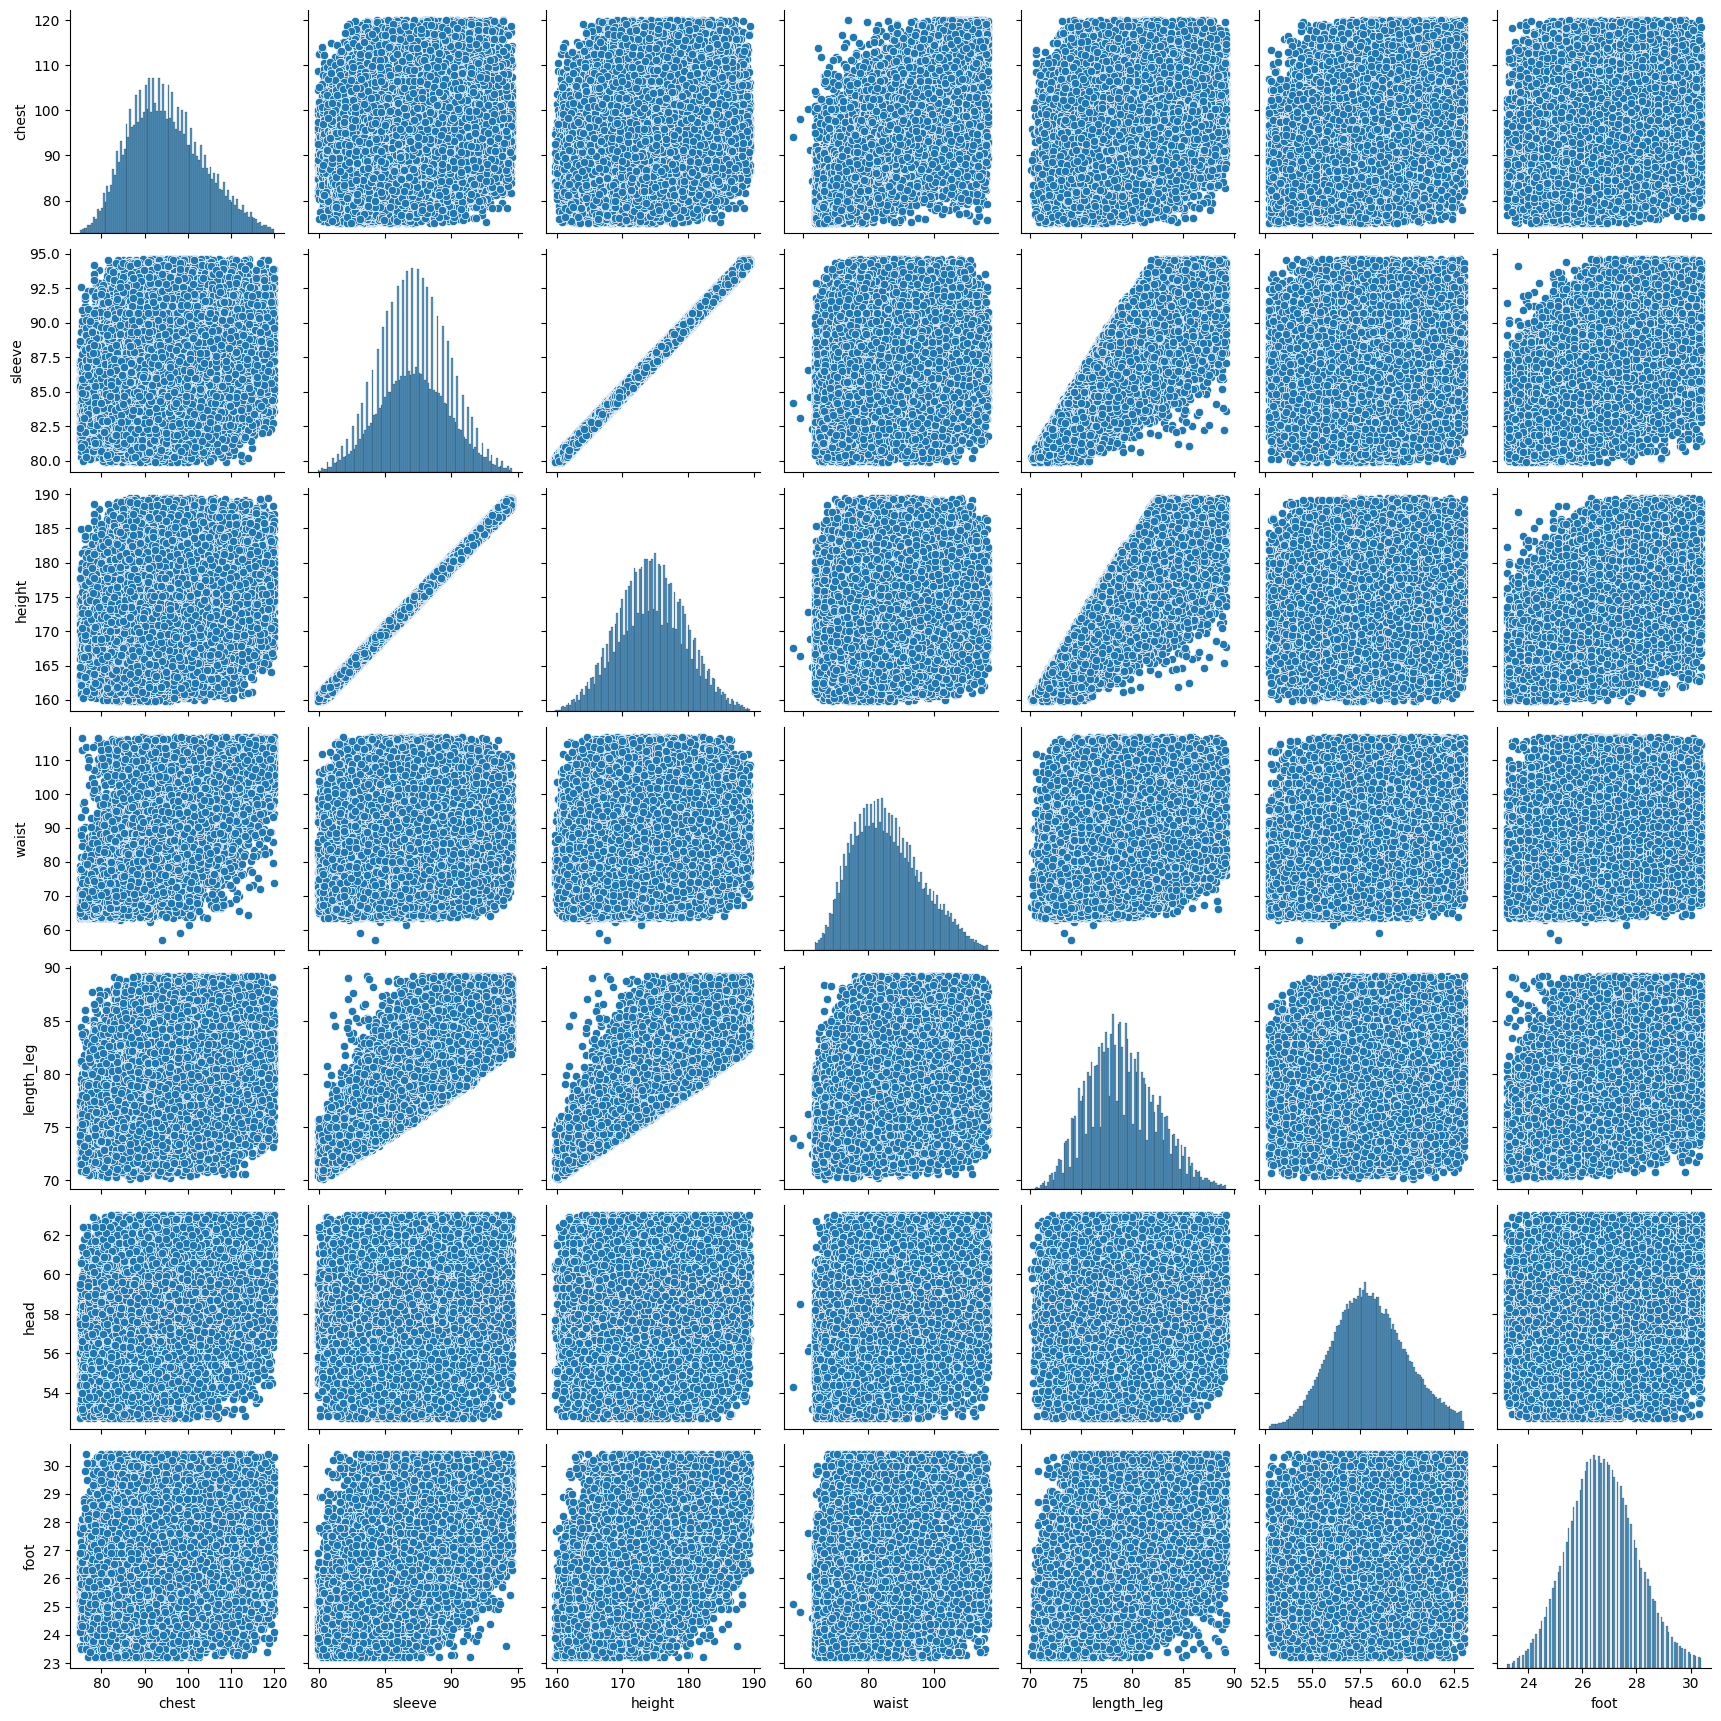

In [15]:
corr_data = new_data.drop('weight', axis = 1)
corr_matrix = corr_data.corr()
sns.pairplot(corr_data)
plt.show()

<Axes: >

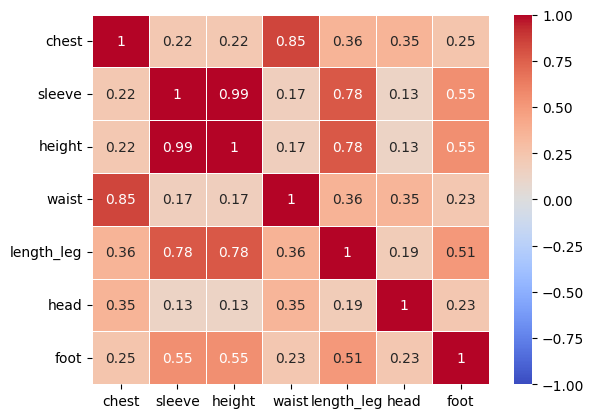

In [16]:
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=.5, vmin=-1, vmax=1)

허리 + 가슴 = 0.85

소매길이 +  키 = 0.99

다리길이 + 소매길이 = 0.77

다리길이 + 키 = 0.78


In [17]:
X = new_data[['height', 'waist', 'foot', 'head']]
y = new_data['weight']

독립변수, 종속변수 세팅

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

test dataset, train dataset 세팅

In [19]:
model = sm.OLS(y_train, X_train).fit()

선형 회귀분석 모델 생성 및 train dataset 으로 훈련

In [20]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 weight   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                 1.271e+05
Date:                Sat, 23 Sep 2023   Prob (F-statistic):               0.00
Time:                        10:56:05   Log-Likelihood:            -3.9892e+05
No. Observations:              127038   AIC:                         7.979e+05
Df Residuals:                  127033   BIC:                         7.979e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -114.6793      0.670   -171.246      0.0

test dataset으로 모델 검증
 * 검증 결과 : R^2는 0.8로 본 모델은 설명력을 가짐. 하지만 다중공선성에 대한 경고를 하고 있음.
  * 상관계수가 큰 계수들을 고려하여 제외했는데 다중공선성이 나타나는 이유를 모르겠음. 해결하기 위해 계수를 일부 조정하겠음.

 * 모델의 가중치는 height : 0.5152, waist : 0.9735, foot : 0.2778, head : 0.088 / 절편은 -114.6793

<Axes: >

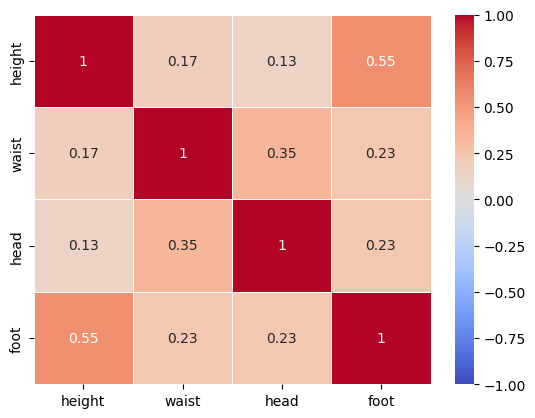

In [21]:
corr_data_2 = new_data.drop(['weight','chest', 'sleeve', 'length_leg'], axis = 1)
corr_matrix_2 = corr_data_2.corr()
sns.heatmap(corr_matrix_2, annot=True, cmap="coolwarm", linewidths=.5, vmin=-1, vmax=1)

여기서 가장 강한 상관계수를 보이는 것은 키와 발의 관계임. 0.55라 중요하지 않다고 여겼지만 다중공선성을 어느정도 제거하기 위해 키를 제거하겠음.
 * 키와 몸무게의 상관관계는 높을 것이 자명하므로 새로운 분석을 위해 제거함

In [23]:
X2 = new_data[['waist', 'foot', 'head']]
y2 = new_data['weight']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=0)
X2_train = sm.add_constant(X2_train)
X2_test = sm.add_constant(X2_test)
model2 = sm.OLS(y2_train, X2_train).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                 weight   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                 1.405e+05
Date:                Sat, 23 Sep 2023   Prob (F-statistic):               0.00
Time:                        10:58:09   Log-Likelihood:            -4.0827e+05
No. Observations:              127038   AIC:                         8.166e+05
Df Residuals:                  127034   BIC:                         8.166e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -55.3866      0.563    -98.301      0.0

가장 상관계수가 높은 변수를 제거하고 선형회귀모델을 다시 만들었음에도 불구하고 다중공선성이 있음을 확인하였음.
 * 본 데이터는 사람의 신체와 관련된 데이터로 변수가 서로 강하게 연결되어있지 않을까 추측됨